In [76]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [77]:
df = pd.read_csv("archive/clean_IMDB3.csv")

X = df["clean_review"]
y = df["sentiment"].map({"positive":1, "negative":0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [79]:
w2v_model = Word2Vec.load("modelW2V/modelWV6.model")

In [80]:
embedding_dim = w2v_model.vector_size
word_vectors = w2v_model.wv

In [81]:
max_words = 20000
max_len = 200 

In [82]:
import ast
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

train_tokens = df.loc[X_train.index, "clean_review"].apply(ast.literal_eval)
tokenizer.fit_on_texts(train_tokens.apply(lambda toks: " ".join(toks)))

In [83]:
X_train_text = train_tokens.apply(lambda toks: " ".join(toks))
test_tokens = df.loc[X_test.index, "clean_review"].apply(ast.literal_eval)
X_test_text  = test_tokens.apply(lambda toks: " ".join(toks))

In [84]:
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

In [85]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
word_index = tokenizer.word_index 
num_words = min(max_words, len(word_index) + 1)

In [ ]:
wv = w2v_model.wv
vocab_w2v = wv.key_to_index

In [88]:
embedding_matrix = np.random.normal(0, 0.05, (num_words, embedding_dim)).astype(np.float32)
embedding_matrix[0] = 0.0

In [89]:
for word, i in word_index.items():
    if i < num_words and word in vocab_w2v:
        embedding_matrix[i] = wv[word]

In [90]:
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len,
              trainable=True, mask_zero=True),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation="sigmoid")
])

c:\Users\djibr\miniconda3\envs\terEnv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [91]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_accuracy", patience=1, restore_best_weights=True)

In [94]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    verbose=1, 
    callbacks=[es]
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 399ms/step - accuracy: 0.8094 - loss: 0.4257 - val_accuracy: 0.7496 - val_loss: 0.5182
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 191s 381ms/step - accuracy: 0.8682 - loss: 0.3207 - val_accuracy: 0.8849 - val_loss: 0.2851
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 188s 377ms/step - accuracy: 0.9027 - loss: 0.2499 - val_accuracy: 0.8792 - val_loss: 0.2952


In [95]:
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print("Accuracy sur test:", acc)

Accuracy sur test: 0.8851000070571899


In [96]:
import pickle, json
with open("lstmtokenizerV4.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [97]:
class_names = ["negative", "positive"]
with open("lstmclass_namesV4.json", "w") as f:
    json.dump(class_names, f)

In [98]:
json.dump({"max_len": max_len}, open("lstmconfigV4.json","w"))

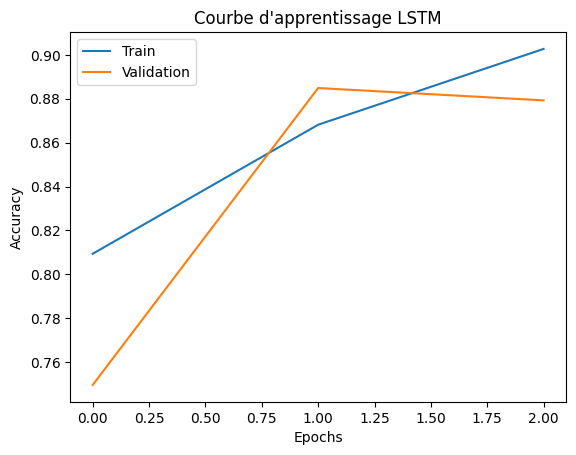

In [99]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()
plt.title("Courbe d'apprentissage LSTM")
plt.show()

In [100]:
model.save("lstmModelV4.h5")
model.save("lstmModelV4.keras")

In [101]:
print(y_train)
print(y_test)

47808    1
20154    0
43069    0
19413    0
13673    0
        ..
31092    1
22917    0
47481    0
35597    0
27491    0
Name: sentiment, Length: 40000, dtype: int64
18870    0
39791    0
30381    1
42294    0
33480    0
        ..
3634     0
47910    0
16086    0
48294    1
4478     0
Name: sentiment, Length: 10000, dtype: int64


In [102]:
in_vocab = 0; total = 0; oov_examples = []
for w, i in word_index.items():
    if i < max_words:
        total += 1
        if w in vocab_w2v:
            in_vocab += 1
        elif len(oov_examples) < 10:
            oov_examples.append(w)
print(f"Couverture W2V : {in_vocab}/{total} = {in_vocab/max(1,total):.3f}")
print("Exemples OOV :", oov_examples)

Couverture W2V : 19998/19999 = 1.000
Exemples OOV : ['<OOV>']


In [ ]:
from tensorflow.keras.models import load_model

modelTest = load_model("lstmModelV4.h5")
tokenizer = pickle.load(open("lstmtokenizerV4.pkl","rb"))
max_len = json.load(open("lstmconfigV4.json"))["max_len"]
class_names = json.load(open("lstmclass_namesV4.json"))

In [ ]:
def pretraitement_review(model, texts, threshold=0.5):
    """
    texts: list of raw reviews (str)
    return: liste (label, positive probabilities)
    """
    seq = tokenizer.texts_to_sequences(texts)
    pad = pad_sequences(seq, maxlen=max_len)

    proba = model.predict(pad, verbose=0).ravel()
    labels_idx = (proba >= threshold).astype(int)
    labels = [class_names[i] for i in labels_idx]
    return list(zip(labels, proba))

In [109]:
samples = [
    "This movie is awful. Boring plot and terrible acting.",
    "Absolutely loved it! Great story and brilliant performances."
]
for lab, p in pretraitement_review(modelTest, samples):
    print(f"{lab}  (proba positive = {p:.3f})")

negative  (proba positive = 0.414)
positive  (proba positive = 0.923)
